# Optcal character recognition
**Author:** Jakub Kosmydel

## Task
Prepare program detecting text on an image.

Text:
- contains only small latin letters and digits,
- contains only one font type and size,
- may contain `.,?!` characters,
- may consist of multiple lines,
- may be rotated.

Consider serif and sans-serif fonts. Program should detect spaces and new lines.

## Imports

In [1]:
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2
from numpy import rot90
from PIL import Image, ImageDraw, ImageFont
from scipy.signal import convolve2d
import string
import cv2
import numpy as np
from scipy import ndimage
from collections import Counter
from time import perf_counter
from tqdm import tqdm
from difflib import SequenceMatcher

## Configuration

In [2]:
# Order in which letters are detected.
# The rest of letters are processed after those.
sequences = [
	['g', 'd', 'b', 'p', 'f', 't', 'h',],
	['a', 'e', 'o', 'q'],
	['k', 'm', 'n', 'r'],
	['4', '1', '8', '3', '0', '6', '9', '2', '5', '7'],
	['x', 'y', 'w', 'u', 's', 'z', 'j', 'l', 'i', 'v']
]

# Letters which are lower than others
LOWER_LINE_CHARACTERS = 'gjypq'

EXTRA_CHARACTERS = "?!.&"

# Letters used to detect whether the text is flipped
upside_down_characters = 'acefghkmrtyz23457'

FONT = 'font/arial.ttf'

## Helper functions
Converting image ot grayscale

In [3]:
def rgb2gray(rgb):
	return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

Counting different letters in text

In [4]:
def letter_count(text):
    return Counter(c for c in text.lower() if c.isalpha())

Finding correlation matrix

In [5]:
def correlation(im1, im2):
	return np.real(ifft2(np.multiply(fft2(im1), fft2(rot90(im2, 2), s=im1.shape))))

Noise reduction in the image

In [6]:
def noise_reduction(img, amount=0.9):
    u, s, vh = np.linalg.svd(img)

    s[int(s.size * amount) + 1:] = 0

    sn = np.zeros((u.shape[0], vh.shape[0]))
    sn[:s.size, :s.size] = np.diag(s)

    return u @ sn @ vh

Finding similarity between two strings

In [7]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def print_similarity(a, b):
	similarity = similar(a, b)
	print(f'Similarity: {similarity:.2f}')
	return similarity

## Main code
### Printing text and returning matrix

In [8]:
def print_text(text, size, imsize=None, offset=(3, 3), rotation=0) -> np.ndarray:
	text = text.lower()
	if imsize is None:
		imsize = [size, size]

	pil_font = ImageFont.truetype(FONT, size=size, encoding="unic")
	text_width, text_height = pil_font.getsize(text)

	# create a blank canvas with extra space between lines
	canvas = Image.new('RGB', imsize, (255, 255, 255))

	# draw the text onto the canvas
	draw = ImageDraw.Draw(canvas)

	white = "#000000"
	draw.text(offset, text, font=pil_font, fill=white, fontstretch='semi-expanded')

	rotated = canvas.rotate(rotation, expand=1, fillcolor=(255, 255, 255))

	gray_scale = rgb2gray((255 - np.asarray(rotated)))

	return gray_scale

### Preparing letter matrix
The function returns:
- matrix representing letter,
- maximum self-correlation.

In [9]:
def prepare_letter(letter, fontsize=50, negative_border=0.8):
	M = print_text(letter, fontsize, [100, 100])

	# Cut the matrix
	M2 = M[~np.all(M == 0, axis=1)]
	M2 = M2[:, ~np.all(M2 == 0, axis=0)]

	# Add border 1 pixel
	M2 = np.pad(M2, pad_width=1, mode='constant', constant_values=0)

	# Add negative values around
	M3 = convolve2d(M2, np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]), mode='same', boundary='wrap')

	RES = np.logical_and(M3 > 0, M2 <= 0)
	M2 -= RES * negative_border

	C = correlation(M, M2)

	return M2, np.max(C)

### Displaying given image with description

In [10]:
def plot_image(img, description=''):
	fig, ax = plt.subplots(figsize=(5, 8))
	ax.imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=np.max(img))
	ax.text(-5, -5, description, fontsize=15)
	plt.show()

### OCR

In [11]:
def ocr(img, font_size=50, display_image=False, threshold=0.98, negative_border=0.5):
	# Shift letters which are below the main text line
	LOWER_LETTER_SHIFT = font_size // 5
	LOWER_LETTERS = set(LOWER_LINE_CHARACTERS)

	# Sort characters in order to get the best results
	characters = set(string.ascii_lowercase + string.digits + EXTRA_CHARACTERS)
	sorted_characters = ""
	for seq in sequences:
		for l in seq:
			sorted_characters += l
			characters.remove(l)

	sorted_characters += ''.join(list(characters))

	# Prepare matrixes for each letter
	letters_images = [prepare_letter(letter, font_size, negative_border=negative_border) for letter in sorted_characters]

	# Prepare matrix to store all correlations for each letter
	img_x, img_y = img.shape
	M = np.empty((len(sorted_characters) + 1, img_x, img_y))
	M[len(sorted_characters)] = np.zeros_like(img)
	M[len(sorted_characters)] += threshold

	# Make a copy of the image - if we process letter we remove it from the copy
	COVERED_IMAGE = img.copy()

	# Spaces matrix for storing spaces in each line (it makes it easier to detect spaces later)
	SPACES = np.zeros_like(img)

	# Plot the input image
	if display_image:
		plot_image(img, 'Input image')

	# Find each letter from the alphabet in the image
	for i, letter in enumerate(sorted_characters):
		# Get letter matrix and maximum self correlation.
		e_img, max_self_correlation = letters_images[i]

		# Compute the correlation
		C = correlation(COVERED_IMAGE, e_img)

		# Scale it properly
		C /= max_self_correlation

		letter_x, letter_y = e_img.shape

		# Letter kernel
		kernel = np.zeros((letter_x*2, letter_y*2))
		kernel[:letter_x, :letter_y] = e_img > 0

		# Remove the letter from the image copy
		COVERED_IMAGE[convolve2d(C > threshold, kernel, mode='same', boundary='wrap') > 0] = 0

		# Shift tall letters
		if letter in LOWER_LETTERS:
			C = np.roll(C, -LOWER_LETTER_SHIFT, axis=0)

		# Save the spaces to the matrix
		spaces_kernel = np.zeros((1, letter_y*2))
		spaces_kernel[:, :letter_y] = 1
		SPACES[convolve2d(C > threshold, spaces_kernel, mode='same', boundary='wrap') > 0] = 1

		# Save correlation to the matrix
		M[i] = C

		# Plot each letter if its needed
		# plot_image((C > threshold) + img / 4 + COVERED_IMAGE/2 + (convolve2d(C > threshold, kernel, mode='same', boundary='wrap') > 0), letter)

	# Calculate the best match for each cell
	res = np.argmax(M, axis=0)

	# Count letters in each line to detect the lines
	letters_in_line = np.sum(res != len(sorted_characters), axis=1)

	#
	# Detect the lines, letters and spaces
	#

	# Index of last non zero row
	start_non_zero = 0
	# [not used] Index of maximum amount of letters in current line
	max_non_zero = 0
	# Amount of zero-letters rows in a row
	zero_count = 0
	# If we are currently processing a line
	is_line = False

	result = []

	for i, v in enumerate(letters_in_line):
		# Edge case - last line
		if len(letters_in_line) - 1 == i:
			if v > 0 and not is_line:
				is_line = True
				max_non_zero = i
				start_non_zero = i
			zero_count = 999

		# Check if we start new line
		if v > 0 and i < len(letters_in_line) - 1:
			if not is_line:
				# We have new line
				max_non_zero = i
				start_non_zero = i
				is_line = True
			else:
				if v > letters_in_line[max_non_zero]:
					max_non_zero = i
		else:
			zero_count += 1
			# Is the line completed?
			if is_line and zero_count > (font_size // 2):
				# We have found the end of the line
				is_line = False
				zero_count = 0

				# check max
				spaces_length = 0
				row_to_check = np.min(res[start_non_zero:i + 1], axis=0)

				new_line = ""
				last_letter_id = -1
				for j, letter_id in enumerate(row_to_check):
					if SPACES[max_non_zero, j] == 0:
						spaces_length += 1
						if spaces_length == 6:
							new_line += " "
					else:
						spaces_length = 0
					if last_letter_id == letter_id:
						continue
					else:
						last_letter_id = letter_id
					if letter_id != len(sorted_characters):
						new_line += sorted_characters[letter_id]
				result.append(new_line)

	return result

## Rotated text management
### Cropping matrix to the content

In [12]:
def crop_to_content(img, threshold=0.5):
	img[img < threshold] = 0
	coords = np.argwhere(img)
	x_min, y_min = coords.min(axis=0)
	x_max, y_max = coords.max(axis=0)
	cropped = img[x_min:x_max+1, y_min:y_max+1]
	cropped = np.pad(cropped, pad_width=1, mode='constant', constant_values=0)

	return cropped

**Example**

Before:

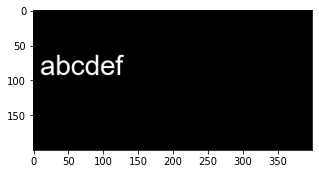

In [13]:
pre_cropped = print_text('abcdef', 40, (400, 200), offset=(10, 50))
plot_image(pre_cropped)

After:

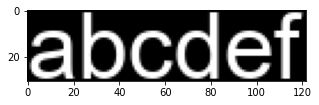

In [14]:
cropped = crop_to_content(pre_cropped)
plot_image(cropped)

### Fixing image rotation

In [15]:
def fix_image(input_img):
	img = np.uint8(input_img)
	edges = cv2.Canny(img, 50, 150, apertureSize = 3)

	lines = cv2.HoughLines(edges,1,np.pi/180,20)
	for rho,theta in lines[0]:
		a = np.cos(theta)
		b = np.sin(theta)
		x0 = a*rho
		y0 = b*rho
		x1 = int(x0 + 1000*(-b))
		y1 = int(y0 + 1000*(a))
		x2 = int(x0 - 1000*(-b))
		y2 = int(y0 - 1000*(a))
		# print('found line', rho, theta)

	if theta is None:
		return img, 0

	angle = (180*theta/np.pi) - 90
	img_proste = img
	if abs(angle) > 1:
		img_proste = ndimage.rotate(input_img, angle, cval=0)

	img_proste = crop_to_content(img_proste)

	return img_proste, -angle

**Example**

Before:

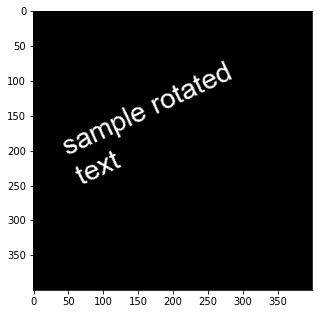

In [16]:
pre_rotate_fix = print_text('sample rotated\ntext',
							 40, (300, 300), offset=(10, 50), rotation=25)
plot_image(pre_rotate_fix)

After:

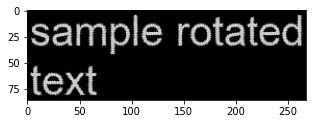

Detected angle: 25.00


In [17]:
rotate_fix, angle = fix_image(pre_rotate_fix)
plot_image(rotate_fix)
print(f'Detected angle: {angle:.2f}')

### Flipping image if it is upside down
It sums detected `upside_down_characters` on two versions of image: original and flipped upside down. Then it flips the image if there are letters detected in upside down version of image.

In [18]:
def fix_flip(img, font_size, threshold=0.95):
	img_upside_down = np.rot90(img, 2)
	count_normal, count_upside_down = 0, 0

	for flip_letter in upside_down_characters:
		letter_matrix, letter_max_correlation = prepare_letter(flip_letter, font_size)
		C1 = correlation(img, letter_matrix) / letter_max_correlation
		count_normal += np.sum(C1 > threshold)
		C2 = correlation(img_upside_down, letter_matrix) / letter_max_correlation
		count_upside_down += np.sum(C2 > threshold)

	if count_upside_down > count_normal * 1.05:
		return img_upside_down, True

	return img, False

**Example**

Before:

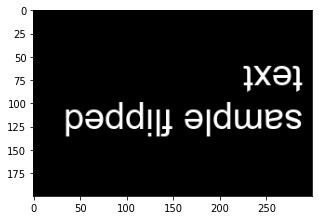

In [19]:
pre_flip_fix = print_text('sample flipped\ntext',
							 40, (300, 200), offset=(10, 50), rotation=180)
plot_image(pre_flip_fix)

After:

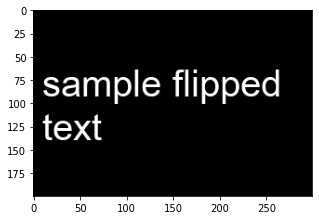

Was flipped? True


In [20]:
flip_fix, was_flipped = fix_flip(pre_flip_fix, font_size=40)
plot_image(flip_fix)
print(f'Was flipped?', was_flipped)

### Complete test function

In [21]:
def universal_ocr_demo(img, font_size=40, threshold=0.95, silent=False):
	if not silent:
		plot_image(img, 'Input image')
	unrotated_img, rotate_angle = fix_image(img)
	if not silent: print(f'Found rotation {rotate_angle:.1f} degree')
	flip_corrected_img, is_flipped = fix_flip(unrotated_img, font_size, threshold=threshold)
	if not silent: print('Flipped image', is_flipped)
	res = ocr(flip_corrected_img, font_size=font_size, threshold=threshold)
	if not silent:
		print('Result:')
		print('--------------------')
		print(*res, sep='\n')
		print('--------------------')
		print('Found letters:')
		i = 0
		for k, v in letter_count(''.join(res)).items():
			print(f'{k}: {v}\t', end='')
			i += 1
			if i == 5:
				print('\n')
				i = 0
		print()
	return '\n'.join(res)

In [22]:
def test_function(text, imsize=(500, 500), rotation=0, offset=(10, 50), threshold=0.95):
	text_img = print_text(text,
						 40,
						 imsize,
						 offset=offset,
						rotation=rotation)
	ocr_text = universal_ocr_demo(text_img, threshold=threshold)
	print_similarity(text, ocr_text)

## Tests
### Sans-serif
#### Alphabet

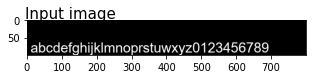

Found rotation -0.0 degree
Flipped image False
Result:
--------------------
abcdefghijklmnoprstuwxyz01 23456789
--------------------
Found letters:
a: 1	b: 1	c: 1	d: 1	e: 1	

f: 1	g: 1	h: 1	i: 1	j: 1	

k: 1	l: 1	m: 1	n: 1	o: 1	

p: 1	r: 1	s: 1	t: 1	u: 1	

w: 1	x: 1	y: 1	z: 1	
Similarity: 0.99


In [23]:
test_function("abcdefghijklmnoprstuwxyz0123456789", imsize=(800, 100))

#### Simple test with space

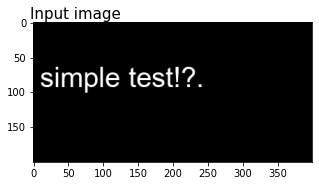

Found rotation -0.0 degree
Flipped image False
Result:
--------------------
simple testi ... .
--------------------
Found letters:
s: 2	i: 2	m: 1	p: 1	l: 1	

e: 2	t: 2	
Similarity: 0.75


In [24]:
test_function('simple test!?.', imsize=(400, 200))

#### Multiline detection

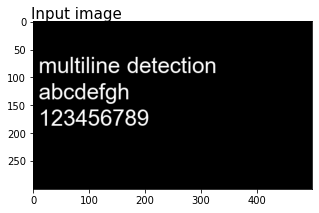

Found rotation -0.0 degree
Flipped image False
Result:
--------------------
multiline detection
abcdefgh 
1 23456789 
--------------------
Found letters:
m: 1	u: 1	l: 2	t: 3	i: 3	

n: 2	e: 4	d: 2	c: 2	o: 1	

a: 1	b: 1	f: 1	g: 1	h: 1	


Similarity: 0.96


In [25]:
test_function('multiline detection\nabcdefgh\n123456789', imsize=(500, 300))

#### Slightly rotated text
We have to lower threshold because the text is distorted.

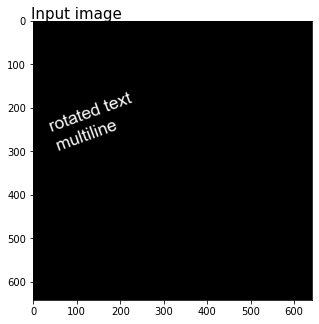

Found rotation 20.0 degree
Flipped image False
Result:
--------------------
rotated te.t
multiline 
--------------------
Found letters:
r: 1	o: 1	t: 5	a: 1	e: 3	

d: 1	m: 1	u: 1	l: 2	i: 2	

n: 1	
Similarity: 0.93


In [26]:
test_function('rotated text\nmultiline', rotation=20, threshold=0.9)

#### Flipped text

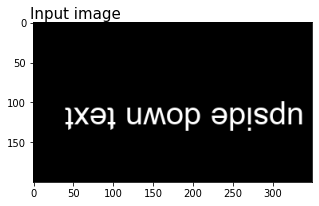

Found rotation -0.0 degree
Flipped image True
Result:
--------------------
upside down text
--------------------
Found letters:
u: 1	p: 1	s: 1	i: 1	d: 2	

e: 2	o: 1	w: 1	n: 1	t: 2	

x: 1	
Similarity: 1.00


In [27]:
test_function('upside down text', imsize=(350, 200), rotation=180, threshold=0.9)

#### Flipped and rotated text
We have to lower threshold because the text is distorted.

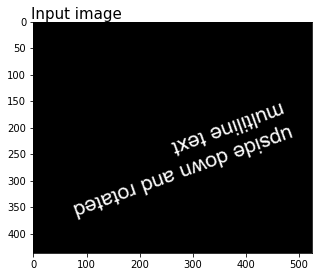

Found rotation 20.0 degree
Flipped image True
Result:
--------------------
upside down and rotated
multiline text 
--------------------
Found letters:
u: 2	p: 1	s: 1	i: 3	d: 4	

e: 4	o: 2	w: 1	n: 3	a: 2	

r: 1	t: 5	m: 1	l: 2	x: 1	


Similarity: 0.99


In [28]:
test_function('upside down and rotated\nmultiline text',
			  imsize=(450, 300), rotation=200, threshold=0.9)

#### Long text

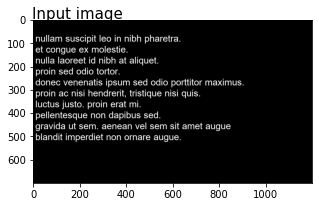

Found rotation -0.0 degree
Flipped image False
Result:
--------------------
nullam suscipit leo in nibh pharetra. 
et congue ex molestie. 
nulla laoreet id nibh at aliquet. 
proin sed odio tortor. 
donec venenatis ipsum sed odio porttitor maximus.
proin ac nisi hendrerit. tristique nisi quis. 
luctus justo. proin erat mi. 
pellentesque non dapibus sed. 
gravida ut sem. aenean vel sem sit amet augue 
blandit imperdiet non ornare augue. 
--------------------
Found letters:
n: 24	u: 19	l: 13	a: 21	m: 10	

s: 20	c: 5	i: 32	p: 10	t: 25	

e: 35	o: 20	b: 4	h: 4	r: 18	

g: 4	x: 2	d: 12	q: 4	v: 3	

j: 1	
Similarity: 0.92


In [29]:
long_text = '''Nullam suscipit leo in nibh pharetra.
et congue ex molestie.
Nulla laoreet id nibh at aliquet.
Proin sed odio tortor.
Donec venenatis ipsum sed odio porttitor maximus.
Proin ac nisi hendrerit, tristique nisi quis.
luctus justo. Proin erat mi.
pellentesque non dapibus sed.
gravida ut sem. Aenean vel sem sit amet augue
blandit imperdiet non ornare augue.'''.lower()

test_function(long_text,
			  imsize=(1200, 700))

#### Simple test with noise reduction

In [30]:
def analyze_noise_reduction(text, rotation):
	NOISE_REDUCTION_STEPS = np.arange(0.05, 1, 0.05)

	x = []
	y = []

	for step in NOISE_REDUCTION_STEPS:
		sample_test = print_text(text,
								 40,
								 (400, 200),
								 offset=(10, 50),
								 rotation=rotation)

		sample_test = noise_reduction(sample_test, step)
		res = universal_ocr_demo(sample_test, threshold=0.9, silent=True)

		similarity = similar(res, text)
		if len(x) % 2 == 0:
			print(f'Noise reduction: \t{step:.2f} Similarity: \t{similarity:.2f}')
		x.append(step)
		y.append(similarity)

	plt.plot(x, y)
	plt.xlabel('Noise reduction ratio')
	plt.ylabel('Similarity (0-1)')
	plt.show()

Noise reduction: 	0.05 Similarity: 	0.08
Noise reduction: 	0.15 Similarity: 	0.13
Noise reduction: 	0.25 Similarity: 	0.64
Noise reduction: 	0.35 Similarity: 	0.76
Noise reduction: 	0.45 Similarity: 	0.76
Noise reduction: 	0.55 Similarity: 	0.76
Noise reduction: 	0.65 Similarity: 	0.76
Noise reduction: 	0.75 Similarity: 	0.76
Noise reduction: 	0.85 Similarity: 	0.76
Noise reduction: 	0.95 Similarity: 	0.76


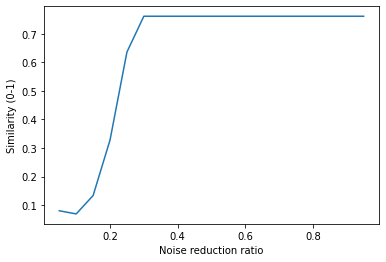

In [31]:
INPUT_TEXT = 'text with\nnoise reduction'
analyze_noise_reduction(INPUT_TEXT, 0)

#### Rotated text with noise reduction

Noise reduction: 	0.05 Similarity: 	0.09
Noise reduction: 	0.15 Similarity: 	0.93
Noise reduction: 	0.25 Similarity: 	0.09
Noise reduction: 	0.35 Similarity: 	0.08
Noise reduction: 	0.45 Similarity: 	0.92
Noise reduction: 	0.55 Similarity: 	0.92
Noise reduction: 	0.65 Similarity: 	0.92
Noise reduction: 	0.75 Similarity: 	0.92
Noise reduction: 	0.85 Similarity: 	0.92
Noise reduction: 	0.95 Similarity: 	0.92


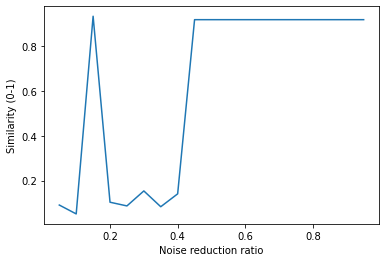

In [32]:
INPUT_TEXT = 'rotated text\nnoise reduction'

analyze_noise_reduction(INPUT_TEXT, 25)

### Serif font

In [33]:
FONT = 'font/timesnewroman.ttf'

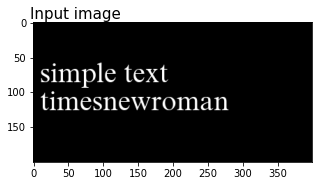

Found rotation -0.0 degree
Flipped image False
Result:
--------------------
t ..w 
s.mmpte text 
t mmesnew roman
--------------------
Found letters:
t: 5	w: 2	s: 2	m: 5	p: 1	

e: 4	x: 1	n: 2	r: 1	o: 1	

a: 1	
Similarity: 0.72


In [34]:
test_function('simple text\ntimesnewroman', threshold=0.85, imsize=(400, 200))

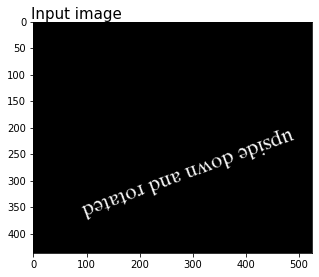

Found rotation 20.0 degree
Flipped image True
Result:
--------------------
 . 
apside down and rotated
--------------------
Found letters:
a: 3	p: 1	s: 1	i: 1	d: 4	

e: 2	o: 2	w: 1	n: 2	r: 1	

t: 2	
Similarity: 0.88


In [35]:
test_function('upside down and rotated',
			  imsize=(450, 300), rotation=200, threshold=0.85)

In [36]:
FONT = 'font/arial.ttf'

## Speed comparison
Text `TEXT` has been divided into `CHUNKS_AMOUNT` chunks.

In [37]:
TEXT = 'Quisque quis ultrices arcu, sit amet viverra leo. Nunc dui augue, bibendum eu augue at, elementum vehicula erat. Mauris euismod suscipit tortor, ac bibendum dolor tincidunt ut. Etiam mollis libero eu.'
CHUNKS_AMOUNT = 22

CHUNKS = [TEXT[i:i+CHUNKS_AMOUNT] for i in range(0, len(TEXT), CHUNKS_AMOUNT)]

x = []
y = []

for i in tqdm(range(1, len(CHUNKS))):
	block_text = '\n'.join(CHUNKS[:i])
	test = print_text(block_text, 40, (1000, 1000), offset=(10, 10))
	t0 = perf_counter()
	universal_ocr_demo(test, silent=True)
	tc = perf_counter() - t0
	x.append(len(block_text))
	y.append(tc)

100%|██████████| 9/9 [02:58<00:00, 19.87s/it]


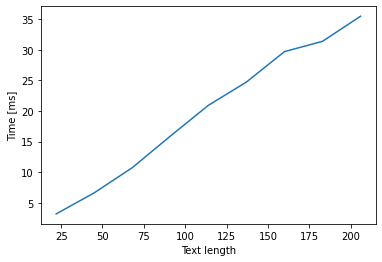

In [38]:
plt.plot(x, y)
plt.xlabel('Text length')
plt.ylabel('Time [ms]')
plt.show()

## Lessons learned
- Algorithm recognizes correctly most of the text (about 90%+).
- It detects spaces and new lines and works with rotated and flipped text.
- To detect original text rotation Hough transform (from CV2 library) was used.
- Most problematic characters are `l`, `i`, `j` which were often confused.
- Serif fonts were more problematic than sans-serif.
- Images with noise reduction after some threshold value (around 0.2-0.5) works correctly.
- Algorithm can be optimized in terms of efficiency (fft is calculated often redundantly multiple times).